In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, 'G:\\My Drive\\Colab Notebooks\\pycode')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pycode.BRDF import linearRoughnessToAlpha
from pycode.NumpyHLSL import frac, Frame, dot, float3
from pycode.MicrofacetDistribution import MicrofacetReflection, BSDFSamplingRecord

In [4]:
def nthSampleR2Sequence(n):
    magic = np.array([0.7548776662466927, 0.5698402909980532])
    return frac(0.5 + magic * (n + 1)).astype(np.float32)


In [5]:
shNormal = np.array([0,1,1])
shNormal = shNormal / np.linalg.norm(shNormal)
shTangent = np.array([1,1,0])
shTangent = shTangent / np.linalg.norm(shTangent)

shFrame = Frame(shNormal, T=None)

for i in range(4):
    print(i)

print(np.modf(1.4)[0])
print(nthSampleR2Sequence(4096*34)-nthSampleR2Sequence(4096*34-1))
print(nthSampleR2Sequence(4096*34).dtype)

0
1
2
3
0.3999999999999999
[-0.24512237 -0.4301597 ]
float32


In [7]:
def specularOcclusion(alphaV, cosBeta, roughness):
    beta = np.arccos(cosBeta)

    thetaC_0 = -beta/2
    thetaO_0 = beta/2 

    thetaO_1 = np.minimum(beta, np.pi/2)
    thetaC_1 = thetaO_1 - beta

    # 0.78 is a magic number that manually tweak for our reference implementation
    factor = 0.78
    thetaO = thetaO_0 * (1 - factor) + thetaO_1 * factor
    thetaC = thetaC_0 * (1 - factor) + thetaC_1 * factor

    B = float3(np.sin(thetaC), np.zeros_like(thetaC), np.cos(thetaC))
    Nx = float3(0, 0, 1)
    Wr = float3(np.sin(thetaO), np.zeros_like(thetaO), np.cos(thetaO))

    frame = Frame(Nx, T=np.where(dot(Nx, Wr) >= 0.99, float3(0,1,0), Wr))

    V = frame.toWorld(Wr)

    sampleCount = 256
    
    accumValue = 0
    accumWeight = 0

    for i in range(sampleCount):
        u_ = nthSampleR2Sequence(i)

        ggxAlpha = linearRoughnessToAlpha(roughness)

        bRec = BSDFSamplingRecord(frame.toLocal(V))
        bsdf = MicrofacetReflection(ggxAlpha, ggxAlpha)

        sampleWeight = bsdf.sample(bRec, u_)
        sampleWeight *= Frame.cosTheta(bRec.wi)

        wi = frame.toWorld(bRec.wi)
        cosThetaI = Frame.cosTheta(bRec.wi)

        if (cosThetaI > 0):
            visible = np.where(np.arccos(dot(B, wi)) < alphaV * np.pi * 0.5, 1.0, 0.0)
            accumValue += visible * sampleWeight
            accumWeight += sampleWeight

    if (accumWeight > 0):
        return accumValue / accumWeight
    else:
        return 0

dim = 32
lut = np.zeros((dim, dim))

alphaV = np.linspace(0, np.pi, dim)
cosBeta = np.cos(np.linspace(0, np.pi/2, dim))
alphaV, cosBeta = np.meshgrid(alphaV, cosBeta)
roughness = np.ones_like(alphaV) * 0.3
lut = specularOcclusion(alphaV, cosBeta, roughness)

plt.imshow(lut, cmap="gray")
plt.show()





ValueError: all input arrays must have the same shape

In [ ]:
%pip install OpenEXR

# W:\SGame\GraphicsPlayground\LocalPackages\com.tencent.tmgp.yarp\Resources\Textures\SpecularOcclusionLut3D.exr

In [ ]:
import OpenEXR
import Imath
import numpy as np

In [ ]:
pt = Imath.PixelType(Imath.PixelType.FLOAT)
golden = OpenEXR.InputFile("/SpecularOcclusionLut3D.exr")

dw = golden.header()['dataWindow']
size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

redstr = golden.channel('R', pt)

lut = np.fromstring(redstr, dtype = np.float32)

lut.shape = (size[1], size[0]) # Numpy arrays are (row, col)
print(lut.shape)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8*8,8))
plt.imshow(lut, cmap="gray")

In [ ]:
print(lut[:, 0:64].shape)

In [ ]:
%matplotlib inline

i = np.linspace(0,1,64)
j = np.linspace(1,-1,64)
i,j = np.meshgrid(i,j)

n_plots = 3
fig, ax = plt.subplots(1, n_plots, figsize=(8*3,4), subplot_kw={"projection": "3d", "proj_type" : "ortho"})

angles = [16, 32, 32+16]
for m, k in enumerate(angles):
    print(m, k)
    data = lut[:, 64*k:64*(k+1)]

    ax[m].set_xlim(0, 1.0)
    ax[m].set_ylim(-1, 1.0)
    ax[m].set_zlim(0, 1.0)
    ax[m].set_xlabel("roughness")
    ax[m].set_ylabel("cosTheta")
    ax[m].set_title("Cone angle: {0}".format((k+1)/64.0*90))
    ax[m].view_init(elev=30., azim=-45)
    ax[m].plot_surface(i,j,data)
#plt.imshow(lut[:, 64*i:64*(i+1)], cmap="gray")

In [ ]:
%matplotlib notebook

In [10]:
import OpenEXR
import Imath
import numpy as np

In [20]:
pt = Imath.PixelType(Imath.PixelType.FLOAT)
golden = OpenEXR.InputFile("/SpecularOcclusionLut3D.exr")

dw = golden.header()['dataWindow']
size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

redstr = golden.channel('R', pt)

lut = np.fromstring(redstr, dtype = np.float32)

lut.shape = (size[1], size[0]) # Numpy arrays are (row, col)
print(lut.shape)


(64, 4096)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


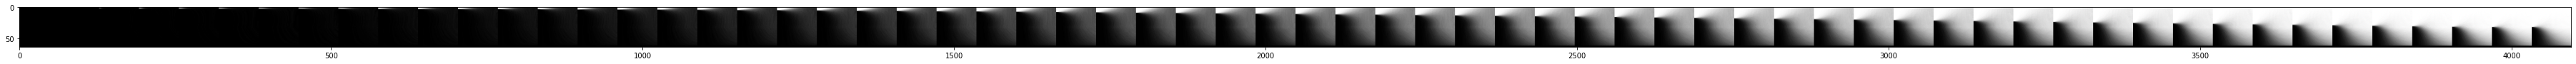

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8*8,8))
plt.imshow(lut, cmap="gray")

In [31]:
print(lut[:, 0:64].shape)

(64, 64)


0 16
1 32
2 48


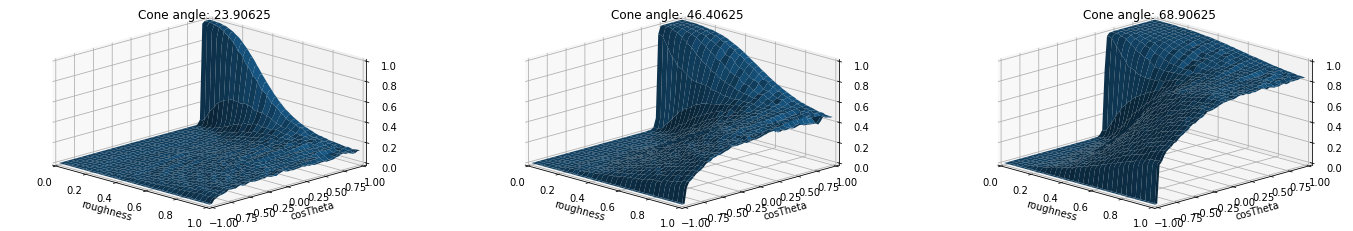

In [107]:
%matplotlib inline

i = np.linspace(0,1,64)
j = np.linspace(1,-1,64)
i,j = np.meshgrid(i,j)

n_plots = 3
fig, ax = plt.subplots(1, n_plots, figsize=(8*3,4), subplot_kw={"projection": "3d", "proj_type" : "ortho"})

angles = [16, 32, 32+16]
for m, k in enumerate(angles):
    print(m, k)
    data = lut[:, 64*k:64*(k+1)]

    ax[m].set_xlim(0, 1.0)
    ax[m].set_ylim(-1, 1.0)
    ax[m].set_zlim(0, 1.0)
    ax[m].set_xlabel("roughness")
    ax[m].set_ylabel("cosTheta")
    ax[m].set_title("Cone angle: {0}".format((k+1)/64.0*90))
    ax[m].view_init(elev=30., azim=-45)
    ax[m].plot_surface(i,j,data)
#plt.imshow(lut[:, 64*i:64*(i+1)], cmap="gray")

In [ ]:
%matplotlib notebook